In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import sympy
from sympy import symbols
from sympy.logic.boolalg import to_cnf

In [82]:
# ==========================================
# 0. CONFIGURAZIONE
# ==========================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 256
LR = 0.001
EPOCHS = 100
N_ITEMS = 5  
W_VALUES = [0.35, 0.55]
RATIO = 0.01

In [83]:
# --- 1. DATASET MNIST SORTING (Modificato) ---
class MNISTSortingDataset(Dataset):
    def __init__(self, mnist_dataset, length=10000):
        self.length = length
        self.n_items = N_ITEMS
        
        print("Caricamento dati in RAM...")
        data = mnist_dataset.data.float() / 255.0
        self.data = (data - 0.1307) / 0.3081
        self.data = self.data.unsqueeze(1) 
        self.targets = mnist_dataset.targets
        print("Dati pronti.")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        indices = torch.randperm(len(self.data))[:self.n_items]
        images = self.data[indices]
        labels = self.targets[indices] # Questi sono i valori dei numeri (es. 3, 0, 9...)
        
        sort_indices = torch.argsort(labels)
        ranks = torch.argsort(sort_indices)
        
        target_matrix = torch.zeros((self.n_items, self.n_items))
        for i in range(self.n_items):
            target_matrix[i, ranks[i]] = 1.0
            
        # RESTITUIAMO ANCHE LE LABELS ORA
        return images, target_matrix, labels


In [84]:
class PrecomputedMNISTSortingDataset(Dataset):
    def __init__(self, images_tensor, labels_tensor, length=10000):
        self.images_tensor = images_tensor
        self.length = length
        self.n_items = N_ITEMS
        
        print(f"Pre-computing {length} targets in RAM...")
        self.indices = torch.randint(0, len(images_tensor), (length, N_ITEMS))
        self.targets = torch.zeros((length, N_ITEMS, N_ITEMS))
        
        # Salviamo anche le etichette del batch per la loss simbolica
        self.batch_labels_store = torch.zeros((length, N_ITEMS), dtype=torch.long)
        
        for i in range(length):
            idxs = self.indices[i]
            batch_labels = labels_tensor[idxs]
            self.batch_labels_store[i] = batch_labels # Store
            
            sort_indices = torch.argsort(batch_labels)
            ranks = torch.argsort(sort_indices)
            for r in range(N_ITEMS):
                self.targets[i, r, ranks[r]] = 1.0
        
        print("Pre-computation finita.")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        img_indices = self.indices[idx]
        images = self.images_tensor[img_indices]
        target = self.targets[idx]
        labels = self.batch_labels_store[idx] # Retrieve
        
        return images, target, labels

In [86]:
class SortingNet(nn.Module):
    def __init__(self):
        super(SortingNet, self).__init__()
        # CNN Feature Extractor (Invariata)
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5), nn.MaxPool2d(2), nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5), nn.MaxPool2d(2), nn.ReLU(),
            nn.Flatten()
        )
        self.feat_dim = 320 
        
        # 1. Riduzione dimensionalità locale (per ogni immagine)
        self.local_proj = nn.Sequential(
            nn.Linear(self.feat_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        # 2. MLP Reasoning potenziata
        self.mlp = nn.Sequential(
            nn.Linear(N_ITEMS * 64, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 256), # Strato extra per profondità
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, N_ITEMS * N_ITEMS) 
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Processamento immagini
        x_reshaped = x.view(batch_size * N_ITEMS, 1, 28, 28)
        features = self.cnn(x_reshaped) # (B*5, 320)
        
        # Proiezione locale (ogni immagine viene "riassunta")
        features = self.local_proj(features) # (B*5, 64)
        
        # Concatenazione per il ragionamento
        features = features.view(batch_size, N_ITEMS * 64) # (B, 320)
        
        out = self.mlp(features)
        out = out.view(batch_size, N_ITEMS, N_ITEMS)
        
        # Ritorna Softmax invece di Sigmoid per validità immediata
        return torch.softmax(out, dim=2)

In [87]:
class CachedSymbolicLoss(torch.nn.Module):
    def __init__(self, n_items=5, n_ranks=5, device='cuda'):
        super().__init__()
        self.n_items = n_items
        self.n_ranks = n_ranks
        self.device = device

        print("Compiling logic into Arithmetic Circuit indices...")
        
        # 1. Generazione simboli e clausole SymPy (Offline)
        sym_grid = [[symbols(f'X_{i}_{r}') for r in range(n_ranks)] for i in range(n_items)]
        
        # Lista per memorizzare tutte le clausole compilate: (item_i, rank_r, item_j, rank_rj)
        # Rappresenta il vincolo: NOT (X_i_r AND X_j_r+1)
        compiled_indices = []

        for i in range(n_items):
            for j in range(n_items):
                if i == j: continue
                for r in range(n_ranks - 1):
                    # Definiamo la regola simbolica
                    rule = ~(sym_grid[i][r] & sym_grid[j][r+1])
                    cnf = to_cnf(rule)
                    
                    # Estraiamo gli indici per il tensore
                    # In una CNF ~(A & B) abbiamo (~A | ~B)
                    # Memorizziamo la coppia (i, r) e (j, r+1) che genera il conflitto
                    compiled_indices.append([i, r, j, r+1])

        # Trasformiamo in un tensore PyTorch per calcoli paralleli ultra-rapidi
        self.register_buffer('indices', torch.LongTensor(compiled_indices))
        print(f"Compiled {len(compiled_indices)} logic constraints.")

    def forward(self, probs, values, epsilon=1e-8):
        """
        Calcolo della WMC (Weighted Model Count) tramite circuito aritmetico tensorizzato.
        """
        batch_size = probs.shape[0]
        
        # 1. Identifichiamo quali vincoli attivare in base ai valori (Knowledge Base)
        # Creiamo una maschera di conflitto (B, N, N)
        val_i = values.unsqueeze(2) 
        val_j = values.unsqueeze(1)
        conflict_mask = (val_i > val_j).float() # 1 se item i > item j

        # 2. Recuperiamo le probabilità dei letterali coinvolti nei vincoli
        # idx: [item_i, rank_r, item_j, rank_rj]
        p_i_r = probs[:, self.indices[:, 0], self.indices[:, 1]]
        p_j_rj = probs[:, self.indices[:, 2], self.indices[:, 3]]

        # 3. Calcolo Probabilità di Violazione: P(A AND B) = P(A) * P(B)
        # Moltiplichiamo per la maschera di conflitto specifica per questo batch
        # Recuperiamo il conflitto relativo alla coppia i, j per ogni vincolo
        batch_conflicts = conflict_mask[:, self.indices[:, 0], self.indices[:, 2]]
        
        prob_violation = (p_i_r * p_j_rj) * batch_conflicts
        
        # 4. Semantic Loss: -log(P(Soddisfazione)) = -log(1 - P(Violazione))
        # Questo è il calcolo del Weighted Model Count derivabile
        prob_sat = torch.clamp(1.0 - prob_violation, min=epsilon, max=1.0)
        
        # Sommiamo i logaritmi delle probabilità di soddisfazione di tutte le clausole
        loss = -torch.log(prob_sat).sum(dim=1)
        
        return loss.mean()

In [88]:
# ==========================================\n# 2. LA SEMANTIC LOSS ESTESA\n# ==========================================
def semantic_loss_exactly_one(probs, epsilon=1e-6):
    """Loss strutturale: righe e colonne devono sommare a 1 (Permutation Matrix)."""
    q = 1.0 - probs
    row_prod = torch.prod(q + epsilon, dim=1, keepdim=True)
    term = probs * (row_prod / (q + epsilon))
    prob_constraint = torch.sum(term, dim=1)
    return torch.mean(-torch.log(prob_constraint + epsilon))

def semantic_loss_sorted_list(matrix_probs, labels, epsilon=1e-6):
    """
    Loss Simbolica di Ordinamento (Pairwise Probabilistic Logic).
    Calcola la probabilità che, date le predizioni, la lista risultante sia ordinata.
    Vincolo: Valore(Posizione j) <= Valore(Posizione j+1)
    """
    # matrix_probs: (Batch, N_items, N_ranks)
    # labels: (Batch, N_items) - I valori reali dei numeri in input
    
    loss = 0
    n_ranks = matrix_probs.shape[2]
    
    # Per ogni posizione j nella sequenza di output (da 0 a N-2)
    for j in range(n_ranks - 1):
        # Probabilità che l'input 'i' finisca al rank 'j'
        prob_at_j = matrix_probs[:, :, j]      # (Batch, N_items)
        # Probabilità che l'input 'k' finisca al rank 'j+1'
        prob_at_j_plus_1 = matrix_probs[:, :, j+1] # (Batch, N_items)
        
        # Calcoliamo la probabilità congiunta per tutte le coppie (i, k)
        # BMM (Batch Matrix Mul): (B, N, 1) x (B, 1, N) -> (B, N, N)
        # joint_prob[b, i, k] = P(item i @ j AND item k @ j+1)
        joint_prob = torch.bmm(prob_at_j.unsqueeze(2), prob_at_j_plus_1.unsqueeze(1))
        
        # Creiamo una maschera logica: 1 se label[i] <= label[k], 0 altrimenti
        # Espandiamo le labels per il broadcasting
        labels_i = labels.unsqueeze(2) # (B, N, 1)
        labels_k = labels.unsqueeze(1) # (B, 1, N)
        
        # Il vincolo è soddisfatto se il numero a sinistra è <= numero a destra
        valid_pair_mask = (labels_i <= labels_k).float()
        
        # Sommiamo le probabilità di tutte le configurazioni valide
        prob_constraint_satisfied = torch.sum(joint_prob * valid_pair_mask, dim=(1, 2))
        
        # Loss = -log(probabilità che il vincolo j, j+1 sia vero)
        loss += torch.mean(-torch.log(prob_constraint_satisfied + epsilon))
        
    return loss
    

def compute_full_semantic_loss(matrix_probs, labels=None):
    """Combina i vincoli strutturali e, se presenti le labels, i vincoli di ordinamento."""
    loss = 0
    # 1. Vincolo Strutturale (Permutation Matrix)
    for i in range(N_ITEMS):
        loss += semantic_loss_exactly_one(matrix_probs[:, i, :]) # Righe
    for j in range(N_ITEMS):
        loss += semantic_loss_exactly_one(matrix_probs[:, :, j]) # Colonne
        
    # 2. Vincolo Simbolico di Ordinamento (Opzionale, se passiamo le labels)
    if labels is not None:
        loss += semantic_loss_sorted_list(matrix_probs, labels)
        
    return loss

def compute_full_semantic_loss_cnf(matrix_probs, labels):
    """
    Combina:
    1. Exactly-One (Struttura della matrice di permutazione)
    2. Ordering CNF (Regole logiche basate sui valori delle label)
    """
    loss = 0.0
    
    # A. Vincoli Strutturali (Righe e Colonne)
    # Nota: exactly_one lavora su vettori 1D, quindi iteriamo
    # Righe (Ogni immagine ha una sola posizione)
    for i in range(matrix_probs.size(1)):
        loss += semantic_loss_exactly_one(matrix_probs[:, i, :])
    # Colonne (Ogni posizione ha una sola immagine)
    for j in range(matrix_probs.size(2)):
        loss += semantic_loss_exactly_one(matrix_probs[:, :, j])
        
    # B. Vincoli Logici (CNF sui valori)
    loss_order = torch.tensor(0.0, device=matrix_probs.device)
    if labels is not None:
        loss_order = semantic_loss_ordering_cnf(matrix_probs, labels)
        loss += loss_order
        
    return loss


def compute_entropy_loss(probs):
    # probs shape: (Batch, 5, 5)
    epsilon = 1e-6
    # Calcola l'entropia per ogni riga (distribuzione di probabilità sulla posizione)
    entropy = -torch.sum(probs * torch.log(probs + epsilon), dim=2)
    return entropy.mean()

In [89]:
def train_semisupervised(model, train_loader, val_loader, use_semantic_loss=True, use_entropy_min=False, use_semantic_loss_cnf=False, labeled_ratio=0.05, epochs=30, w_semantic=0.4):    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion_none = nn.BCELoss(reduction='none') 
    W_ENTROPY = 0.1
    
    print(f"\n--- Training Semi-Sup | Labels: {labeled_ratio*100}% | Semantic Loss: {use_semantic_loss or use_semantic_loss_cnf} | W_SEMANTIC: {w_semantic} ---")
    
    history = {'loss': [], 'validity': [], 'accuracy': []}
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        current_w = 0.0
        if use_semantic_loss or use_semantic_loss_cnf:
            current_w = w_semantic
            
        desc = f"Epoch {epoch+1} (W={current_w})"
        progress_bar = tqdm(train_loader, desc=desc, ascii=True)
        
        # MODIFICA QUI: Unpack di 3 elementi (imgs, targets, labels)
        for i, (imgs, targets, labels) in enumerate(progress_bar):
            imgs, targets, labels = imgs.to(DEVICE), targets.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            out = model(imgs)
            
            # 1. MASCHERA SEMI-SUPERVISIONATA
            mask_labeled = (torch.rand(imgs.size(0)) < labeled_ratio).float().to(DEVICE)
            
            # 2. LOSS SUPERVISIONATA
            raw_sup = criterion_none(out, targets)
            mask_expanded = mask_labeled.view(-1, 1, 1)
            masked_sup_loss = raw_sup * mask_expanded
            
            num_labeled = mask_labeled.sum()
            sup_loss = masked_sup_loss.sum() / num_labeled if num_labeled > 0 else torch.tensor(0.0).to(DEVICE)
            
            # 3. SEMANTIC LOSS (Include ora il controllo ordinamento)
            sem_loss = torch.tensor(0.0).to(DEVICE)
            if current_w > 0 and use_semantic_loss:
                # Passiamo 'labels' per attivare anche la loss simbolica sull'ordinamento
                sem_loss = compute_full_semantic_loss(out, labels)

            elif current_w > 0 and use_semantic_loss_cnf:
                sem_loss = cnf_loss_fn(out, labels)

            # 3,1. ENTROPY LOSS
            ent_loss = torch.tensor(0.0).to(DEVICE)
            if use_entropy_min:
                ent_loss = compute_entropy_loss(out)

            # 4. COMBINAZIONE
            if num_labeled > 0:
                loss = ((1.0 - current_w) * sup_loss) + (current_w * sem_loss)
            else:
                loss = sem_loss 

            if use_entropy_min:
                loss = loss + (W_ENTROPY * ent_loss)
            
            if loss.requires_grad:
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            
            progress_bar.set_postfix(sup=f"{sup_loss:.3f}", sem=f"{sem_loss:.3f}", ent=f"{ent_loss:.3f}")
            
        # --- VALUTAZIONE (Invariata, ma bisogna gestire l'unpack nel loop se necessario) ---
        model.eval()
        valid_count = 0
        exact_match = 0
        total = 0
        with torch.no_grad():
            # Anche qui il loader ora restituisce 3 valori
            for x, y, _ in val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                out = model(x)
                preds = torch.argmax(out, dim=2)
                targs = torch.argmax(y, dim=2)
                
                for b in range(x.size(0)):
                    if len(torch.unique(preds[b])) == N_ITEMS:
                        valid_count += 1
                
                matches = (preds == targs).all(dim=1)
                exact_match += matches.sum().item()
                total += x.size(0)
        
        val_validity = 100 * valid_count / total
        val_accuracy = 100 * exact_match / total
        
        history['loss'].append(total_loss / len(train_loader))
        history['validity'].append(val_validity)
        history['accuracy'].append(val_accuracy)
        
        print(f"Epoch {epoch+1} | Validity: {val_validity:.2f}% | Exact Match: {val_accuracy:.2f}%")
        
    return history

In [90]:
# --- A. Caricamento e Pre-processing in RAM (Una volta sola) ---
print("Caricamento dataset MNIST in RAM...")
# Scarichiamo i dati raw
raw_train = datasets.MNIST('./data', train=True, download=True)
raw_test = datasets.MNIST('./data', train=False, download=True)

# Convertiamo TUTTO in tensori float e normalizziamo SUBITO
# Training (60k)
X_all = raw_train.data.float() / 255.0
X_all = (X_all - 0.1307) / 0.3081
X_all = X_all.unsqueeze(1) # Shape: (60000, 1, 28, 28)
Y_all = raw_train.targets

# Test (10k)
X_test = raw_test.data.float() / 255.0
X_test = (X_test - 0.1307) / 0.3081
X_test = X_test.unsqueeze(1)
Y_test = raw_test.targets

# --- B. Split Manuale dei Tensori (80% Train / 20% Val) ---
# Non usiamo random_split sui dataset, ma splittiamo i tensori stessi
split_idx = int(0.8 * len(X_all)) # 48.000

# Slicing dei tensori (crea viste in memoria, molto efficiente)
X_train, X_val = X_all[:split_idx], X_all[split_idx:]
Y_train, Y_val = Y_all[:split_idx], Y_all[split_idx:]

print(f"Dati in RAM -> Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# --- C. Creazione Dataset Veloci ---
# Passiamo i tensori specifici a ogni dataset
# length=... definisce quante "triplette" generare per epoca. 
# Mettiamo valori alti per sfruttare i dati.
train_ds = PrecomputedMNISTSortingDataset(X_train, Y_train, length=48000)
val_ds = PrecomputedMNISTSortingDataset(X_val, Y_val, length=2000)
test_ds = PrecomputedMNISTSortingDataset(X_test, Y_test, length=10000)

# DataLoader (num_workers=0 è obbligatorio qui per evitare overhead inutile)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Setup completato. Ready to train!")

Caricamento dataset MNIST in RAM...
Dati in RAM -> Train: 48000, Val: 12000, Test: 10000
Pre-computing 48000 targets in RAM...
Pre-computation finita.
Pre-computing 2000 targets in RAM...
Pre-computation finita.
Pre-computing 10000 targets in RAM...
Pre-computation finita.
Setup completato. Ready to train!


In [91]:
# --- ESPERIMENTO CON DIVERSI VALORI DI W_SEMANTIC ---

# Valori di W_SEMANTIC da testare
w_values = [0.35, 0.55]

# Dizionario per salvare i risultati
results = {}
results_cnf = {}

cnf_loss_fn = CachedSymbolicLoss(n_items=5, n_ranks=5, device=DEVICE)

for w in W_VALUES:
    print(f"\n{'='*60}")
    print(f">>> TRAINING CON W_SEMANTIC = {w}")
    print(f"{'='*60}")
    
    model = SortingNet().to(DEVICE)
    hist = train_semisupervised(model, train_loader, val_loader, 
                                use_semantic_loss=False, 
                                use_entropy_min=True,
                                use_semantic_loss_cnf=(w > 0),
                                labeled_ratio=RATIO, 
                                epochs=EPOCHS,
                                w_semantic=w)
    
    results_cnf[w] = {
        'model': model,
        'history': hist
    }

for w in W_VALUES:
    print(f"\n{'='*60}")
    print(f">>> TRAINING CON W_SEMANTIC = {w}")
    print(f"{'='*60}")
    
    model = SortingNet().to(DEVICE)
    hist = train_semisupervised(model, train_loader, val_loader, 
                                use_semantic_loss=(w > 0), 
                                use_entropy_min=True,
                                use_semantic_loss_cnf=False,
                                labeled_ratio=RATIO, 
                                epochs=EPOCHS,
                                w_semantic=w)
    
    results[w] = {
        'model': model,
        'history': hist
    }

# --- TRAINING BASELINE (Senza Semantic Loss per confronto) ---
print(f"\n{'='*60}")
print(">>> TRAINING BASELINE (No Semantic Loss)")
print(f"{'='*60}")
model_base = SortingNet().to(DEVICE)
hist_base = train_semisupervised(model_base, train_loader, val_loader, 
                                 use_semantic_loss=False, 
                                 use_entropy_min=True,
                                 use_semantic_loss_cnf=False,
                                 labeled_ratio=RATIO, 
                                 epochs=EPOCHS)


Compiling logic into Arithmetic Circuit indices...
Compiled 80 logic constraints.

>>> TRAINING CON W_SEMANTIC = 0.35

--- Training Semi-Sup | Labels: 1.0% | Semantic Loss: True | W_SEMANTIC: 0.35 ---


Epoch 1 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 | Validity: 6.65% | Exact Match: 0.15%


Epoch 2 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 | Validity: 11.55% | Exact Match: 1.25%


Epoch 3 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3 | Validity: 12.00% | Exact Match: 1.85%


Epoch 4 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4 | Validity: 17.15% | Exact Match: 3.80%


Epoch 5 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5 | Validity: 21.50% | Exact Match: 4.95%


Epoch 6 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6 | Validity: 24.85% | Exact Match: 5.90%


Epoch 7 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7 | Validity: 24.35% | Exact Match: 7.30%


Epoch 8 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8 | Validity: 25.50% | Exact Match: 8.75%


Epoch 9 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9 | Validity: 27.00% | Exact Match: 9.85%


Epoch 10 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10 | Validity: 26.25% | Exact Match: 9.25%


Epoch 11 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11 | Validity: 27.10% | Exact Match: 8.60%


Epoch 12 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12 | Validity: 28.60% | Exact Match: 11.95%


Epoch 13 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13 | Validity: 31.20% | Exact Match: 12.90%


Epoch 14 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14 | Validity: 35.45% | Exact Match: 13.55%


Epoch 15 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 15 | Validity: 36.85% | Exact Match: 13.60%


Epoch 16 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 16 | Validity: 34.15% | Exact Match: 14.55%


Epoch 17 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 17 | Validity: 34.15% | Exact Match: 14.15%


Epoch 18 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 18 | Validity: 36.20% | Exact Match: 17.25%


Epoch 19 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 19 | Validity: 36.45% | Exact Match: 16.15%


Epoch 20 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 20 | Validity: 43.45% | Exact Match: 20.50%


Epoch 21 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 21 | Validity: 42.25% | Exact Match: 19.25%


Epoch 22 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 22 | Validity: 38.80% | Exact Match: 18.85%


Epoch 23 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 23 | Validity: 45.30% | Exact Match: 22.20%


Epoch 24 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 24 | Validity: 43.40% | Exact Match: 20.45%


Epoch 25 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 25 | Validity: 44.60% | Exact Match: 21.40%


Epoch 26 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 26 | Validity: 45.05% | Exact Match: 23.50%


Epoch 27 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 27 | Validity: 43.55% | Exact Match: 22.45%


Epoch 28 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 28 | Validity: 49.25% | Exact Match: 28.20%


Epoch 29 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 29 | Validity: 48.95% | Exact Match: 26.05%


Epoch 30 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 30 | Validity: 47.10% | Exact Match: 26.15%


Epoch 31 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 31 | Validity: 49.60% | Exact Match: 25.40%


Epoch 32 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 32 | Validity: 50.75% | Exact Match: 27.65%


Epoch 33 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 33 | Validity: 50.40% | Exact Match: 27.40%


Epoch 34 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 34 | Validity: 53.40% | Exact Match: 27.80%


Epoch 35 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 35 | Validity: 52.20% | Exact Match: 30.60%


Epoch 36 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 36 | Validity: 56.35% | Exact Match: 34.95%


Epoch 37 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 37 | Validity: 54.00% | Exact Match: 31.70%


Epoch 38 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 38 | Validity: 53.75% | Exact Match: 31.40%


Epoch 39 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 39 | Validity: 52.55% | Exact Match: 32.50%


Epoch 40 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 40 | Validity: 54.40% | Exact Match: 32.75%


Epoch 41 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 41 | Validity: 57.85% | Exact Match: 34.85%


Epoch 42 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 42 | Validity: 58.35% | Exact Match: 37.35%


Epoch 43 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 43 | Validity: 58.40% | Exact Match: 37.30%


Epoch 44 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 44 | Validity: 57.70% | Exact Match: 33.00%


Epoch 45 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 45 | Validity: 60.75% | Exact Match: 36.40%


Epoch 46 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 46 | Validity: 61.15% | Exact Match: 39.70%


Epoch 47 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 47 | Validity: 60.15% | Exact Match: 38.80%


Epoch 48 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 48 | Validity: 61.50% | Exact Match: 40.40%


Epoch 49 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 49 | Validity: 61.60% | Exact Match: 39.55%


Epoch 50 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 50 | Validity: 60.85% | Exact Match: 41.30%


Epoch 51 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 51 | Validity: 61.25% | Exact Match: 41.80%


Epoch 52 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 52 | Validity: 60.90% | Exact Match: 40.50%


Epoch 53 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 53 | Validity: 63.80% | Exact Match: 41.60%


Epoch 54 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 54 | Validity: 65.10% | Exact Match: 43.00%


Epoch 55 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 55 | Validity: 60.65% | Exact Match: 40.25%


Epoch 56 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 56 | Validity: 65.65% | Exact Match: 46.55%


Epoch 57 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 57 | Validity: 62.95% | Exact Match: 43.35%


Epoch 58 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 58 | Validity: 65.00% | Exact Match: 45.55%


Epoch 59 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 59 | Validity: 63.15% | Exact Match: 41.75%


Epoch 60 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 60 | Validity: 63.55% | Exact Match: 43.75%


Epoch 61 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 61 | Validity: 66.30% | Exact Match: 46.70%


Epoch 62 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 62 | Validity: 66.25% | Exact Match: 46.75%


Epoch 63 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 63 | Validity: 63.55% | Exact Match: 41.85%


Epoch 64 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 64 | Validity: 66.25% | Exact Match: 46.85%


Epoch 65 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 65 | Validity: 66.70% | Exact Match: 47.55%


Epoch 66 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 66 | Validity: 66.00% | Exact Match: 46.25%


Epoch 67 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 67 | Validity: 66.15% | Exact Match: 47.00%


Epoch 68 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 68 | Validity: 68.35% | Exact Match: 47.30%


Epoch 69 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 69 | Validity: 67.75% | Exact Match: 48.50%


Epoch 70 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 70 | Validity: 67.90% | Exact Match: 47.80%


Epoch 71 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 71 | Validity: 68.00% | Exact Match: 48.85%


Epoch 72 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 72 | Validity: 69.25% | Exact Match: 51.35%


Epoch 73 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 73 | Validity: 69.15% | Exact Match: 47.95%


Epoch 74 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 74 | Validity: 67.05% | Exact Match: 47.35%


Epoch 75 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 75 | Validity: 71.85% | Exact Match: 53.15%


Epoch 76 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 76 | Validity: 71.85% | Exact Match: 53.05%


Epoch 77 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 77 | Validity: 70.40% | Exact Match: 53.90%


Epoch 78 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 78 | Validity: 71.15% | Exact Match: 53.80%


Epoch 79 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 79 | Validity: 68.70% | Exact Match: 51.25%


Epoch 80 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 80 | Validity: 71.15% | Exact Match: 53.45%


Epoch 81 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 81 | Validity: 72.00% | Exact Match: 54.80%


Epoch 82 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 82 | Validity: 71.65% | Exact Match: 56.20%


Epoch 83 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 83 | Validity: 70.80% | Exact Match: 54.65%


Epoch 84 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 84 | Validity: 70.65% | Exact Match: 53.75%


Epoch 85 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 85 | Validity: 71.05% | Exact Match: 55.65%


Epoch 86 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 86 | Validity: 71.00% | Exact Match: 54.70%


Epoch 87 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 87 | Validity: 70.70% | Exact Match: 54.35%


Epoch 88 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 88 | Validity: 71.65% | Exact Match: 54.70%


Epoch 89 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 89 | Validity: 72.45% | Exact Match: 55.15%


Epoch 90 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 90 | Validity: 73.35% | Exact Match: 56.05%


Epoch 91 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 91 | Validity: 70.75% | Exact Match: 55.80%


Epoch 92 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 92 | Validity: 73.05% | Exact Match: 57.15%


Epoch 93 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 93 | Validity: 74.15% | Exact Match: 57.90%


Epoch 94 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 94 | Validity: 72.70% | Exact Match: 57.00%


Epoch 95 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 95 | Validity: 73.50% | Exact Match: 59.05%


Epoch 96 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 96 | Validity: 71.95% | Exact Match: 56.60%


Epoch 97 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 97 | Validity: 71.50% | Exact Match: 56.55%


Epoch 98 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 98 | Validity: 73.05% | Exact Match: 57.45%


Epoch 99 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 99 | Validity: 73.25% | Exact Match: 56.95%


Epoch 100 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 100 | Validity: 72.90% | Exact Match: 56.85%

>>> TRAINING CON W_SEMANTIC = 0.55

--- Training Semi-Sup | Labels: 1.0% | Semantic Loss: True | W_SEMANTIC: 0.55 ---


Epoch 1 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 | Validity: 0.30% | Exact Match: 0.15%


Epoch 2 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 | Validity: 4.30% | Exact Match: 1.05%


Epoch 3 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3 | Validity: 18.15% | Exact Match: 3.05%


Epoch 4 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4 | Validity: 17.15% | Exact Match: 4.05%


Epoch 5 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5 | Validity: 22.85% | Exact Match: 5.50%


Epoch 6 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6 | Validity: 24.25% | Exact Match: 7.55%


Epoch 7 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7 | Validity: 21.25% | Exact Match: 5.95%


Epoch 8 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8 | Validity: 25.95% | Exact Match: 9.00%


Epoch 9 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9 | Validity: 27.20% | Exact Match: 9.60%


Epoch 10 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10 | Validity: 30.25% | Exact Match: 11.50%


Epoch 11 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11 | Validity: 28.60% | Exact Match: 9.20%


Epoch 12 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12 | Validity: 31.55% | Exact Match: 11.85%


Epoch 13 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13 | Validity: 29.70% | Exact Match: 12.05%


Epoch 14 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14 | Validity: 32.75% | Exact Match: 12.45%


Epoch 15 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 15 | Validity: 34.00% | Exact Match: 14.20%


Epoch 16 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 16 | Validity: 36.10% | Exact Match: 15.25%


Epoch 17 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 17 | Validity: 38.05% | Exact Match: 18.45%


Epoch 18 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 18 | Validity: 39.55% | Exact Match: 17.65%


Epoch 19 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 19 | Validity: 41.25% | Exact Match: 19.90%


Epoch 20 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 20 | Validity: 42.15% | Exact Match: 21.00%


Epoch 21 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 21 | Validity: 41.50% | Exact Match: 19.85%


Epoch 22 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 22 | Validity: 40.65% | Exact Match: 20.55%


Epoch 23 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 23 | Validity: 42.05% | Exact Match: 24.20%


Epoch 24 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 24 | Validity: 43.15% | Exact Match: 22.30%


Epoch 25 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 25 | Validity: 45.55% | Exact Match: 24.45%


Epoch 26 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 26 | Validity: 46.30% | Exact Match: 24.90%


Epoch 27 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 27 | Validity: 45.20% | Exact Match: 24.70%


Epoch 28 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 28 | Validity: 47.90% | Exact Match: 27.75%


Epoch 29 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 29 | Validity: 49.30% | Exact Match: 28.70%


Epoch 30 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 30 | Validity: 48.45% | Exact Match: 26.05%


Epoch 31 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 31 | Validity: 51.10% | Exact Match: 29.60%


Epoch 32 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 32 | Validity: 48.95% | Exact Match: 28.95%


Epoch 33 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 33 | Validity: 52.00% | Exact Match: 30.70%


Epoch 34 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 34 | Validity: 55.30% | Exact Match: 33.70%


Epoch 35 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 35 | Validity: 52.55% | Exact Match: 30.75%


Epoch 36 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 36 | Validity: 52.85% | Exact Match: 32.15%


Epoch 37 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 37 | Validity: 59.25% | Exact Match: 37.85%


Epoch 38 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 38 | Validity: 55.95% | Exact Match: 34.05%


Epoch 39 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 39 | Validity: 54.15% | Exact Match: 32.75%


Epoch 40 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 40 | Validity: 57.35% | Exact Match: 37.65%


Epoch 41 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 41 | Validity: 57.35% | Exact Match: 37.65%


Epoch 42 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 42 | Validity: 58.00% | Exact Match: 36.10%


Epoch 43 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 43 | Validity: 59.40% | Exact Match: 39.00%


Epoch 44 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 44 | Validity: 59.25% | Exact Match: 38.70%


Epoch 45 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 45 | Validity: 58.10% | Exact Match: 39.35%


Epoch 46 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 46 | Validity: 61.05% | Exact Match: 39.10%


Epoch 47 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 47 | Validity: 59.40% | Exact Match: 42.40%


Epoch 48 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 48 | Validity: 60.80% | Exact Match: 42.55%


Epoch 49 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 49 | Validity: 59.00% | Exact Match: 40.15%


Epoch 50 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 50 | Validity: 61.00% | Exact Match: 41.10%


Epoch 51 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 51 | Validity: 60.45% | Exact Match: 41.70%


Epoch 52 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 52 | Validity: 64.10% | Exact Match: 43.30%


Epoch 53 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 53 | Validity: 64.85% | Exact Match: 45.00%


Epoch 54 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 54 | Validity: 65.10% | Exact Match: 43.60%


Epoch 55 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 55 | Validity: 63.45% | Exact Match: 42.70%


Epoch 56 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 56 | Validity: 64.10% | Exact Match: 43.70%


Epoch 57 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 57 | Validity: 65.65% | Exact Match: 45.55%


Epoch 58 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 58 | Validity: 63.75% | Exact Match: 45.15%


Epoch 59 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 59 | Validity: 66.70% | Exact Match: 49.25%


Epoch 60 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 60 | Validity: 63.70% | Exact Match: 43.65%


Epoch 61 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 61 | Validity: 63.05% | Exact Match: 44.15%


Epoch 62 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 62 | Validity: 65.55% | Exact Match: 46.70%


Epoch 63 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 63 | Validity: 66.65% | Exact Match: 46.80%


Epoch 64 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 64 | Validity: 67.10% | Exact Match: 49.80%


Epoch 65 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 65 | Validity: 68.35% | Exact Match: 47.55%


Epoch 66 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 66 | Validity: 66.60% | Exact Match: 50.30%


Epoch 67 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 67 | Validity: 66.45% | Exact Match: 47.30%


Epoch 68 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 68 | Validity: 67.00% | Exact Match: 49.30%


Epoch 69 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 69 | Validity: 69.70% | Exact Match: 52.25%


Epoch 70 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 70 | Validity: 68.50% | Exact Match: 50.45%


Epoch 71 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 71 | Validity: 67.45% | Exact Match: 47.80%


Epoch 72 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 72 | Validity: 67.50% | Exact Match: 52.35%


Epoch 73 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 73 | Validity: 68.15% | Exact Match: 51.75%


Epoch 74 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 74 | Validity: 68.85% | Exact Match: 51.40%


Epoch 75 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 75 | Validity: 69.55% | Exact Match: 51.95%


Epoch 76 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 76 | Validity: 68.50% | Exact Match: 52.70%


Epoch 77 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 77 | Validity: 71.75% | Exact Match: 56.00%


Epoch 78 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 78 | Validity: 70.50% | Exact Match: 53.70%


Epoch 79 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 79 | Validity: 67.05% | Exact Match: 49.75%


Epoch 80 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 80 | Validity: 70.05% | Exact Match: 53.10%


Epoch 81 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 81 | Validity: 72.75% | Exact Match: 55.50%


Epoch 82 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 82 | Validity: 71.60% | Exact Match: 53.65%


Epoch 83 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 83 | Validity: 71.55% | Exact Match: 55.10%


Epoch 84 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 84 | Validity: 72.55% | Exact Match: 57.55%


Epoch 85 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 85 | Validity: 72.10% | Exact Match: 55.70%


Epoch 86 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 86 | Validity: 71.80% | Exact Match: 54.60%


Epoch 87 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 87 | Validity: 70.55% | Exact Match: 55.30%


Epoch 88 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 88 | Validity: 71.40% | Exact Match: 54.45%


Epoch 89 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 89 | Validity: 73.75% | Exact Match: 58.20%


Epoch 90 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 90 | Validity: 71.65% | Exact Match: 54.45%


Epoch 91 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 91 | Validity: 74.45% | Exact Match: 58.00%


Epoch 92 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 92 | Validity: 75.70% | Exact Match: 60.40%


Epoch 93 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 93 | Validity: 77.65% | Exact Match: 61.60%


Epoch 94 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 94 | Validity: 72.85% | Exact Match: 57.30%


Epoch 95 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 95 | Validity: 75.85% | Exact Match: 60.20%


Epoch 96 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 96 | Validity: 76.35% | Exact Match: 59.30%


Epoch 97 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 97 | Validity: 74.75% | Exact Match: 59.10%


Epoch 98 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 98 | Validity: 74.80% | Exact Match: 59.85%


Epoch 99 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 99 | Validity: 77.05% | Exact Match: 62.90%


Epoch 100 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 100 | Validity: 75.50% | Exact Match: 60.65%

>>> TRAINING CON W_SEMANTIC = 0.35

--- Training Semi-Sup | Labels: 1.0% | Semantic Loss: True | W_SEMANTIC: 0.35 ---


Epoch 1 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 | Validity: 5.10% | Exact Match: 0.20%


Epoch 2 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 | Validity: 18.55% | Exact Match: 2.05%


Epoch 3 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3 | Validity: 22.60% | Exact Match: 4.10%


Epoch 4 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4 | Validity: 28.80% | Exact Match: 6.45%


Epoch 5 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5 | Validity: 26.00% | Exact Match: 6.00%


Epoch 6 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6 | Validity: 29.45% | Exact Match: 8.25%


Epoch 7 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7 | Validity: 28.85% | Exact Match: 9.05%


Epoch 8 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8 | Validity: 29.95% | Exact Match: 9.45%


Epoch 9 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9 | Validity: 32.95% | Exact Match: 11.20%


Epoch 10 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10 | Validity: 34.55% | Exact Match: 11.35%


Epoch 11 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11 | Validity: 34.60% | Exact Match: 13.50%


Epoch 12 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12 | Validity: 38.15% | Exact Match: 10.50%


Epoch 13 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13 | Validity: 38.80% | Exact Match: 14.85%


Epoch 14 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14 | Validity: 41.10% | Exact Match: 15.40%


Epoch 15 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 15 | Validity: 40.45% | Exact Match: 14.95%


Epoch 16 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 16 | Validity: 42.65% | Exact Match: 13.70%


Epoch 17 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 17 | Validity: 45.50% | Exact Match: 17.85%


Epoch 18 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 18 | Validity: 46.00% | Exact Match: 18.55%


Epoch 19 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 19 | Validity: 46.30% | Exact Match: 18.00%


Epoch 20 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 20 | Validity: 46.10% | Exact Match: 20.15%


Epoch 21 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 21 | Validity: 47.65% | Exact Match: 22.20%


Epoch 22 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 22 | Validity: 52.35% | Exact Match: 25.80%


Epoch 23 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 23 | Validity: 53.40% | Exact Match: 24.60%


Epoch 24 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 24 | Validity: 52.15% | Exact Match: 24.90%


Epoch 25 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 25 | Validity: 50.85% | Exact Match: 24.35%


Epoch 26 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 26 | Validity: 51.30% | Exact Match: 25.00%


Epoch 27 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 27 | Validity: 51.70% | Exact Match: 25.75%


Epoch 28 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 28 | Validity: 54.05% | Exact Match: 28.95%


Epoch 29 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 29 | Validity: 57.35% | Exact Match: 31.70%


Epoch 30 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 30 | Validity: 55.35% | Exact Match: 29.25%


Epoch 31 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 31 | Validity: 57.60% | Exact Match: 31.05%


Epoch 32 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 32 | Validity: 59.25% | Exact Match: 32.60%


Epoch 33 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 33 | Validity: 59.70% | Exact Match: 30.10%


Epoch 34 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 34 | Validity: 59.50% | Exact Match: 34.30%


Epoch 35 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 35 | Validity: 65.00% | Exact Match: 37.35%


Epoch 36 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 36 | Validity: 62.90% | Exact Match: 37.55%


Epoch 37 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 37 | Validity: 61.45% | Exact Match: 33.90%


Epoch 38 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 38 | Validity: 64.10% | Exact Match: 37.50%


Epoch 39 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 39 | Validity: 63.85% | Exact Match: 36.70%


Epoch 40 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 40 | Validity: 64.15% | Exact Match: 39.15%


Epoch 41 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 41 | Validity: 65.25% | Exact Match: 38.70%


Epoch 42 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 42 | Validity: 67.65% | Exact Match: 42.10%


Epoch 43 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 43 | Validity: 66.55% | Exact Match: 40.30%


Epoch 44 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 44 | Validity: 68.45% | Exact Match: 44.40%


Epoch 45 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 45 | Validity: 67.55% | Exact Match: 42.45%


Epoch 46 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 46 | Validity: 69.55% | Exact Match: 44.60%


Epoch 47 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 47 | Validity: 68.10% | Exact Match: 41.40%


Epoch 48 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 48 | Validity: 69.80% | Exact Match: 45.20%


Epoch 49 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 49 | Validity: 69.30% | Exact Match: 43.80%


Epoch 50 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 50 | Validity: 68.60% | Exact Match: 44.25%


Epoch 51 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 51 | Validity: 70.95% | Exact Match: 46.15%


Epoch 52 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 52 | Validity: 71.20% | Exact Match: 46.00%


Epoch 53 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 53 | Validity: 70.40% | Exact Match: 46.40%


Epoch 54 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 54 | Validity: 71.05% | Exact Match: 47.35%


Epoch 55 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 55 | Validity: 70.80% | Exact Match: 47.40%


Epoch 56 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 56 | Validity: 71.30% | Exact Match: 47.80%


Epoch 57 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 57 | Validity: 72.50% | Exact Match: 48.45%


Epoch 58 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 58 | Validity: 73.25% | Exact Match: 49.40%


Epoch 59 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 59 | Validity: 74.35% | Exact Match: 50.80%


Epoch 60 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 60 | Validity: 72.50% | Exact Match: 48.80%


Epoch 61 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 61 | Validity: 71.40% | Exact Match: 50.30%


Epoch 62 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 62 | Validity: 75.80% | Exact Match: 53.35%


Epoch 63 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 63 | Validity: 72.25% | Exact Match: 51.35%


Epoch 64 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 64 | Validity: 74.65% | Exact Match: 51.75%


Epoch 65 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 65 | Validity: 74.90% | Exact Match: 51.90%


Epoch 66 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 66 | Validity: 73.05% | Exact Match: 52.30%


Epoch 67 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 67 | Validity: 74.35% | Exact Match: 52.05%


Epoch 68 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 68 | Validity: 75.70% | Exact Match: 56.00%


Epoch 69 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 69 | Validity: 72.80% | Exact Match: 53.80%


Epoch 70 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 70 | Validity: 75.30% | Exact Match: 55.70%


Epoch 71 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 71 | Validity: 76.85% | Exact Match: 55.25%


Epoch 72 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 72 | Validity: 73.85% | Exact Match: 53.60%


Epoch 73 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 73 | Validity: 73.95% | Exact Match: 53.00%


Epoch 74 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 74 | Validity: 76.35% | Exact Match: 56.05%


Epoch 75 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 75 | Validity: 76.10% | Exact Match: 57.80%


Epoch 76 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 76 | Validity: 76.35% | Exact Match: 55.95%


Epoch 77 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 77 | Validity: 76.95% | Exact Match: 56.70%


Epoch 78 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 78 | Validity: 78.45% | Exact Match: 59.55%


Epoch 79 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 79 | Validity: 75.95% | Exact Match: 58.05%


Epoch 80 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 80 | Validity: 76.15% | Exact Match: 57.10%


Epoch 81 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 81 | Validity: 76.80% | Exact Match: 55.20%


Epoch 82 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 82 | Validity: 76.10% | Exact Match: 58.20%


Epoch 83 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 83 | Validity: 77.75% | Exact Match: 60.55%


Epoch 84 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 84 | Validity: 79.15% | Exact Match: 60.80%


Epoch 85 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 85 | Validity: 78.85% | Exact Match: 59.95%


Epoch 86 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 86 | Validity: 79.70% | Exact Match: 61.25%


Epoch 87 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 87 | Validity: 78.80% | Exact Match: 61.15%


Epoch 88 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 88 | Validity: 78.45% | Exact Match: 61.45%


Epoch 89 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 89 | Validity: 78.50% | Exact Match: 61.90%


Epoch 90 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 90 | Validity: 78.75% | Exact Match: 61.15%


Epoch 91 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 91 | Validity: 80.80% | Exact Match: 63.65%


Epoch 92 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 92 | Validity: 80.45% | Exact Match: 64.85%


Epoch 93 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 93 | Validity: 78.20% | Exact Match: 61.30%


Epoch 94 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 94 | Validity: 78.55% | Exact Match: 63.65%


Epoch 95 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 95 | Validity: 76.75% | Exact Match: 59.75%


Epoch 96 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 96 | Validity: 78.75% | Exact Match: 62.90%


Epoch 97 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 97 | Validity: 77.95% | Exact Match: 60.20%


Epoch 98 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 98 | Validity: 77.70% | Exact Match: 61.90%


Epoch 99 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 99 | Validity: 80.55% | Exact Match: 65.60%


Epoch 100 (W=0.35):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 100 | Validity: 81.15% | Exact Match: 64.40%

>>> TRAINING CON W_SEMANTIC = 0.55

--- Training Semi-Sup | Labels: 1.0% | Semantic Loss: True | W_SEMANTIC: 0.55 ---


Epoch 1 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 | Validity: 13.00% | Exact Match: 0.95%


Epoch 2 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 | Validity: 26.85% | Exact Match: 3.45%


Epoch 3 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3 | Validity: 28.60% | Exact Match: 4.50%


Epoch 4 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4 | Validity: 38.45% | Exact Match: 7.15%


Epoch 5 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5 | Validity: 33.85% | Exact Match: 8.30%


Epoch 6 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6 | Validity: 35.75% | Exact Match: 10.50%


Epoch 7 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7 | Validity: 35.10% | Exact Match: 11.25%


Epoch 8 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8 | Validity: 40.75% | Exact Match: 14.25%


Epoch 9 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9 | Validity: 44.80% | Exact Match: 13.90%


Epoch 10 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10 | Validity: 43.45% | Exact Match: 13.90%


Epoch 11 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11 | Validity: 45.60% | Exact Match: 14.90%


Epoch 12 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12 | Validity: 49.35% | Exact Match: 17.95%


Epoch 13 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13 | Validity: 47.10% | Exact Match: 17.85%


Epoch 14 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14 | Validity: 46.45% | Exact Match: 17.70%


Epoch 15 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 15 | Validity: 51.35% | Exact Match: 21.70%


Epoch 16 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 16 | Validity: 49.45% | Exact Match: 22.05%


Epoch 17 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 17 | Validity: 54.85% | Exact Match: 25.35%


Epoch 18 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 18 | Validity: 57.25% | Exact Match: 26.00%


Epoch 19 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 19 | Validity: 59.60% | Exact Match: 25.05%


Epoch 20 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 20 | Validity: 58.30% | Exact Match: 28.70%


Epoch 21 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 21 | Validity: 61.25% | Exact Match: 30.30%


Epoch 22 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 22 | Validity: 63.60% | Exact Match: 33.15%


Epoch 23 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 23 | Validity: 64.00% | Exact Match: 33.80%


Epoch 24 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 24 | Validity: 60.80% | Exact Match: 29.55%


Epoch 25 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 25 | Validity: 64.30% | Exact Match: 32.15%


Epoch 26 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 26 | Validity: 66.65% | Exact Match: 35.90%


Epoch 27 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 27 | Validity: 67.25% | Exact Match: 35.35%


Epoch 28 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 28 | Validity: 67.25% | Exact Match: 34.35%


Epoch 29 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 29 | Validity: 66.40% | Exact Match: 35.90%


Epoch 30 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 30 | Validity: 67.15% | Exact Match: 37.50%


Epoch 31 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 31 | Validity: 68.25% | Exact Match: 38.90%


Epoch 32 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 32 | Validity: 70.70% | Exact Match: 40.30%


Epoch 33 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 33 | Validity: 72.45% | Exact Match: 43.90%


Epoch 34 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 34 | Validity: 70.70% | Exact Match: 41.20%


Epoch 35 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 35 | Validity: 68.85% | Exact Match: 35.45%


Epoch 36 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 36 | Validity: 73.35% | Exact Match: 42.30%


Epoch 37 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 37 | Validity: 71.60% | Exact Match: 40.80%


Epoch 38 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 38 | Validity: 71.90% | Exact Match: 40.40%


Epoch 39 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 39 | Validity: 72.25% | Exact Match: 42.70%


Epoch 40 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 40 | Validity: 74.50% | Exact Match: 44.65%


Epoch 41 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 41 | Validity: 72.80% | Exact Match: 44.00%


Epoch 42 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 42 | Validity: 75.05% | Exact Match: 44.45%


Epoch 43 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 43 | Validity: 73.25% | Exact Match: 45.35%


Epoch 44 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 44 | Validity: 73.80% | Exact Match: 46.90%


Epoch 45 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 45 | Validity: 75.00% | Exact Match: 47.95%


Epoch 46 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 46 | Validity: 73.10% | Exact Match: 43.80%


Epoch 47 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 47 | Validity: 74.95% | Exact Match: 46.60%


Epoch 48 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 48 | Validity: 75.85% | Exact Match: 48.85%


Epoch 49 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 49 | Validity: 73.55% | Exact Match: 46.45%


Epoch 50 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 50 | Validity: 76.70% | Exact Match: 47.25%


Epoch 51 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 51 | Validity: 75.60% | Exact Match: 49.65%


Epoch 52 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 52 | Validity: 75.75% | Exact Match: 48.40%


Epoch 53 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 53 | Validity: 74.20% | Exact Match: 48.00%


Epoch 54 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 54 | Validity: 76.00% | Exact Match: 49.10%


Epoch 55 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 55 | Validity: 78.65% | Exact Match: 52.15%


Epoch 56 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 56 | Validity: 75.65% | Exact Match: 50.95%


Epoch 57 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 57 | Validity: 78.45% | Exact Match: 52.45%


Epoch 58 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 58 | Validity: 77.75% | Exact Match: 52.75%


Epoch 59 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 59 | Validity: 78.00% | Exact Match: 54.55%


Epoch 60 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 60 | Validity: 78.40% | Exact Match: 55.50%


Epoch 61 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 61 | Validity: 76.60% | Exact Match: 52.15%


Epoch 62 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 62 | Validity: 79.30% | Exact Match: 55.15%


Epoch 63 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 63 | Validity: 79.25% | Exact Match: 56.10%


Epoch 64 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 64 | Validity: 79.35% | Exact Match: 56.45%


Epoch 65 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 65 | Validity: 77.55% | Exact Match: 54.80%


Epoch 66 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 66 | Validity: 78.20% | Exact Match: 53.70%


Epoch 67 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 67 | Validity: 80.15% | Exact Match: 56.60%


Epoch 68 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 68 | Validity: 79.20% | Exact Match: 56.85%


Epoch 69 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 69 | Validity: 79.10% | Exact Match: 55.50%


Epoch 70 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 70 | Validity: 80.10% | Exact Match: 57.95%


Epoch 71 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 71 | Validity: 79.35% | Exact Match: 57.70%


Epoch 72 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 72 | Validity: 78.30% | Exact Match: 55.60%


Epoch 73 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 73 | Validity: 78.95% | Exact Match: 55.65%


Epoch 74 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 74 | Validity: 79.95% | Exact Match: 57.35%


Epoch 75 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 75 | Validity: 78.25% | Exact Match: 58.10%


Epoch 76 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 76 | Validity: 80.15% | Exact Match: 59.05%


Epoch 77 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 77 | Validity: 80.90% | Exact Match: 60.05%


Epoch 78 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 78 | Validity: 78.70% | Exact Match: 59.35%


Epoch 79 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 79 | Validity: 77.80% | Exact Match: 54.00%


Epoch 80 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 80 | Validity: 78.95% | Exact Match: 55.10%


Epoch 81 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 81 | Validity: 80.20% | Exact Match: 58.30%


Epoch 82 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 82 | Validity: 81.00% | Exact Match: 62.80%


Epoch 83 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 83 | Validity: 82.10% | Exact Match: 63.35%


Epoch 84 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 84 | Validity: 82.65% | Exact Match: 62.00%


Epoch 85 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 85 | Validity: 82.35% | Exact Match: 61.35%


Epoch 86 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 86 | Validity: 81.10% | Exact Match: 62.30%


Epoch 87 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 87 | Validity: 81.85% | Exact Match: 63.05%


Epoch 88 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 88 | Validity: 80.55% | Exact Match: 58.70%


Epoch 89 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 89 | Validity: 80.80% | Exact Match: 58.85%


Epoch 90 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 90 | Validity: 82.40% | Exact Match: 62.95%


Epoch 91 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 91 | Validity: 81.10% | Exact Match: 61.25%


Epoch 92 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 92 | Validity: 81.80% | Exact Match: 62.40%


Epoch 93 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 93 | Validity: 82.00% | Exact Match: 62.55%


Epoch 94 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 94 | Validity: 84.50% | Exact Match: 64.05%


Epoch 95 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 95 | Validity: 83.95% | Exact Match: 62.95%


Epoch 96 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 96 | Validity: 84.55% | Exact Match: 63.40%


Epoch 97 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 97 | Validity: 82.75% | Exact Match: 64.40%


Epoch 98 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 98 | Validity: 83.25% | Exact Match: 64.80%


Epoch 99 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 99 | Validity: 84.25% | Exact Match: 63.35%


Epoch 100 (W=0.55):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 100 | Validity: 82.70% | Exact Match: 64.60%

>>> TRAINING BASELINE (No Semantic Loss)

--- Training Semi-Sup | Labels: 1.0% | Semantic Loss: False | W_SEMANTIC: 0.4 ---


Epoch 1 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 | Validity: 9.40% | Exact Match: 0.30%


Epoch 2 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 | Validity: 12.30% | Exact Match: 1.50%


Epoch 3 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3 | Validity: 14.20% | Exact Match: 1.85%


Epoch 4 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4 | Validity: 19.40% | Exact Match: 3.90%


Epoch 5 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5 | Validity: 24.95% | Exact Match: 6.00%


Epoch 6 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6 | Validity: 23.10% | Exact Match: 5.35%


Epoch 7 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7 | Validity: 26.60% | Exact Match: 6.95%


Epoch 8 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8 | Validity: 21.05% | Exact Match: 6.35%


Epoch 9 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9 | Validity: 25.60% | Exact Match: 7.70%


Epoch 10 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10 | Validity: 24.35% | Exact Match: 6.95%


Epoch 11 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11 | Validity: 28.95% | Exact Match: 10.75%


Epoch 12 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12 | Validity: 30.40% | Exact Match: 10.55%


Epoch 13 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13 | Validity: 28.75% | Exact Match: 10.40%


Epoch 14 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14 | Validity: 31.50% | Exact Match: 12.50%


Epoch 15 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 15 | Validity: 30.05% | Exact Match: 12.05%


Epoch 16 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 16 | Validity: 31.75% | Exact Match: 13.35%


Epoch 17 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 17 | Validity: 34.10% | Exact Match: 14.15%


Epoch 18 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 18 | Validity: 33.30% | Exact Match: 13.35%


Epoch 19 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 19 | Validity: 32.65% | Exact Match: 13.60%


Epoch 20 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 20 | Validity: 36.70% | Exact Match: 14.20%


Epoch 21 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 21 | Validity: 39.20% | Exact Match: 15.85%


Epoch 22 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 22 | Validity: 38.15% | Exact Match: 15.75%


Epoch 23 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 23 | Validity: 38.50% | Exact Match: 15.30%


Epoch 24 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 24 | Validity: 38.40% | Exact Match: 17.15%


Epoch 25 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 25 | Validity: 39.50% | Exact Match: 18.95%


Epoch 26 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 26 | Validity: 40.85% | Exact Match: 19.55%


Epoch 27 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 27 | Validity: 43.10% | Exact Match: 22.45%


Epoch 28 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 28 | Validity: 45.35% | Exact Match: 23.30%


Epoch 29 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 29 | Validity: 47.35% | Exact Match: 25.70%


Epoch 30 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 30 | Validity: 46.45% | Exact Match: 25.05%


Epoch 31 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 31 | Validity: 44.25% | Exact Match: 22.90%


Epoch 32 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 32 | Validity: 47.20% | Exact Match: 24.50%


Epoch 33 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 33 | Validity: 48.30% | Exact Match: 28.00%


Epoch 34 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 34 | Validity: 48.30% | Exact Match: 27.95%


Epoch 35 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 35 | Validity: 48.75% | Exact Match: 26.20%


Epoch 36 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 36 | Validity: 49.80% | Exact Match: 25.30%


Epoch 37 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 37 | Validity: 52.05% | Exact Match: 28.45%


Epoch 38 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 38 | Validity: 50.95% | Exact Match: 29.55%


Epoch 39 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 39 | Validity: 50.45% | Exact Match: 28.20%


Epoch 40 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 40 | Validity: 52.10% | Exact Match: 31.95%


Epoch 41 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 41 | Validity: 52.25% | Exact Match: 30.65%


Epoch 42 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 42 | Validity: 53.45% | Exact Match: 32.85%


Epoch 43 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 43 | Validity: 58.90% | Exact Match: 35.75%


Epoch 44 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 44 | Validity: 55.75% | Exact Match: 34.00%


Epoch 45 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 45 | Validity: 56.90% | Exact Match: 33.95%


Epoch 46 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 46 | Validity: 55.00% | Exact Match: 32.25%


Epoch 47 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 47 | Validity: 54.85% | Exact Match: 32.80%


Epoch 48 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 48 | Validity: 55.60% | Exact Match: 34.00%


Epoch 49 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 49 | Validity: 55.00% | Exact Match: 32.05%


Epoch 50 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 50 | Validity: 59.20% | Exact Match: 37.55%


Epoch 51 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 51 | Validity: 58.25% | Exact Match: 37.55%


Epoch 52 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 52 | Validity: 56.80% | Exact Match: 37.35%


Epoch 53 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 53 | Validity: 57.10% | Exact Match: 36.45%


Epoch 54 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 54 | Validity: 58.75% | Exact Match: 36.50%


Epoch 55 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 55 | Validity: 60.15% | Exact Match: 39.15%


Epoch 56 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 56 | Validity: 62.20% | Exact Match: 39.95%


Epoch 57 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 57 | Validity: 57.95% | Exact Match: 36.95%


Epoch 58 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 58 | Validity: 60.20% | Exact Match: 40.00%


Epoch 59 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 59 | Validity: 56.90% | Exact Match: 36.30%


Epoch 60 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 60 | Validity: 61.30% | Exact Match: 40.30%


Epoch 61 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 61 | Validity: 63.55% | Exact Match: 43.25%


Epoch 62 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 62 | Validity: 60.00% | Exact Match: 39.05%


Epoch 63 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 63 | Validity: 61.40% | Exact Match: 39.85%


Epoch 64 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 64 | Validity: 62.80% | Exact Match: 41.50%


Epoch 65 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 65 | Validity: 62.65% | Exact Match: 43.50%


Epoch 66 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 66 | Validity: 64.70% | Exact Match: 44.90%


Epoch 67 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 67 | Validity: 63.30% | Exact Match: 41.45%


Epoch 68 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 68 | Validity: 64.00% | Exact Match: 43.95%


Epoch 69 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 69 | Validity: 61.00% | Exact Match: 43.05%


Epoch 70 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 70 | Validity: 65.90% | Exact Match: 47.00%


Epoch 71 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 71 | Validity: 63.70% | Exact Match: 42.90%


Epoch 72 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 72 | Validity: 66.55% | Exact Match: 46.30%


Epoch 73 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 73 | Validity: 66.00% | Exact Match: 47.40%


Epoch 74 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 74 | Validity: 66.10% | Exact Match: 46.20%


Epoch 75 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 75 | Validity: 63.40% | Exact Match: 43.85%


Epoch 76 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 76 | Validity: 66.30% | Exact Match: 47.40%


Epoch 77 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 77 | Validity: 66.90% | Exact Match: 47.90%


Epoch 78 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 78 | Validity: 68.30% | Exact Match: 48.65%


Epoch 79 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 79 | Validity: 69.05% | Exact Match: 50.00%


Epoch 80 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 80 | Validity: 65.85% | Exact Match: 47.40%


Epoch 81 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 81 | Validity: 66.30% | Exact Match: 46.30%


Epoch 82 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 82 | Validity: 70.15% | Exact Match: 50.15%


Epoch 83 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 83 | Validity: 68.55% | Exact Match: 48.25%


Epoch 84 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 84 | Validity: 66.45% | Exact Match: 47.90%


Epoch 85 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 85 | Validity: 68.00% | Exact Match: 48.90%


Epoch 86 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 86 | Validity: 69.35% | Exact Match: 51.10%


Epoch 87 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 87 | Validity: 70.10% | Exact Match: 51.75%


Epoch 88 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 88 | Validity: 68.55% | Exact Match: 50.00%


Epoch 89 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 89 | Validity: 70.50% | Exact Match: 53.05%


Epoch 90 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 90 | Validity: 69.80% | Exact Match: 52.35%


Epoch 91 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 91 | Validity: 70.50% | Exact Match: 52.50%


Epoch 92 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 92 | Validity: 71.35% | Exact Match: 52.55%


Epoch 93 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 93 | Validity: 69.25% | Exact Match: 53.85%


Epoch 94 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 94 | Validity: 67.05% | Exact Match: 50.05%


Epoch 95 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 95 | Validity: 73.95% | Exact Match: 56.00%


Epoch 96 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 96 | Validity: 70.75% | Exact Match: 55.75%


Epoch 97 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 97 | Validity: 70.10% | Exact Match: 54.35%


Epoch 98 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 98 | Validity: 73.50% | Exact Match: 58.05%


Epoch 99 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 99 | Validity: 72.25% | Exact Match: 56.35%


Epoch 100 (W=0.0):   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 100 | Validity: 72.40% | Exact Match: 54.40%


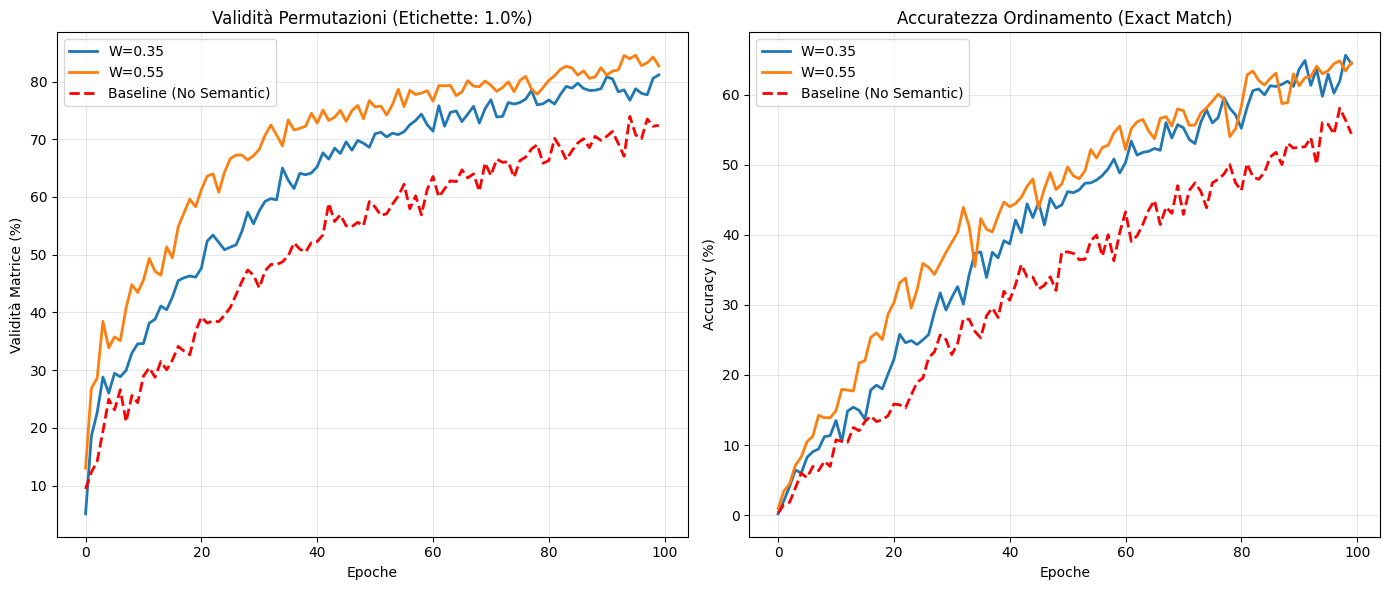

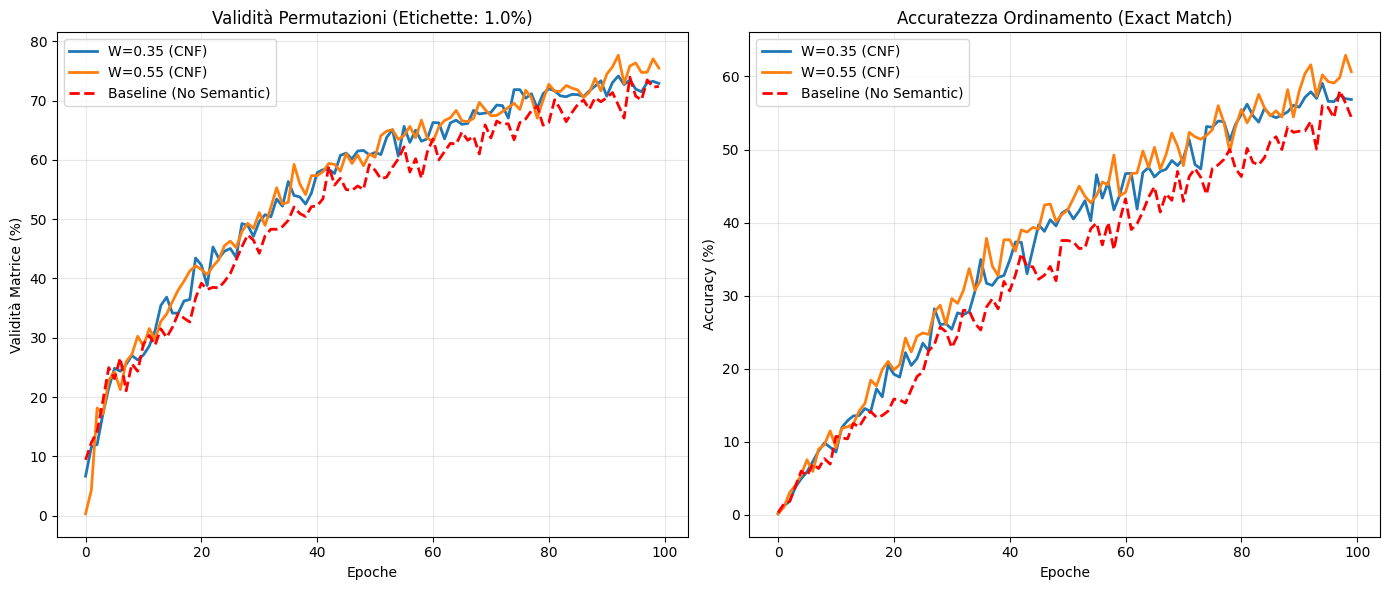


RIEPILOGO RISULTATI FINALI:
W_SEMANTIC = 0.35 -> Validity: 81.15% | Accuracy: 64.40%
W_SEMANTIC = 0.35 -> Validity con CNF: 56.85% | Accuracy con CNF: 56.85%
------------------------------------------------------------
W_SEMANTIC = 0.55 -> Validity: 82.70% | Accuracy: 64.60%
W_SEMANTIC = 0.55 -> Validity con CNF: 60.65% | Accuracy con CNF: 60.65%
------------------------------------------------------------
Baseline          -> Validity: 72.40% | Accuracy: 54.40%


In [92]:
# --- GRAFICI COMPARATIVI ---
plt.figure(figsize=(14, 6))

# Grafico Validità
plt.subplot(1, 2, 1)
for w in W_VALUES:
    plt.plot(results[w]['history']['validity'], label=f'W={w}', linewidth=2)
plt.plot(hist_base['validity'], label='Baseline (No Semantic)', color='red', linestyle='--', linewidth=2)
plt.title(f"Validità Permutazioni (Etichette: {RATIO*100}%)")
plt.xlabel("Epoche")
plt.ylabel("Validità Matrice (%)")
plt.legend()
plt.grid(alpha=0.3)

# Grafico Accuracy
plt.subplot(1, 2, 2)
for w in W_VALUES:
    plt.plot(results[w]['history']['accuracy'], label=f'W={w}', linewidth=2)
plt.plot(hist_base['accuracy'], label='Baseline (No Semantic)', color='red', linestyle='--', linewidth=2)
plt.title(f"Accuratezza Ordinamento (Exact Match)")
plt.xlabel("Epoche")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Grafico Validità con CNF
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
for w in W_VALUES:
    plt.plot(results_cnf[w]['history']['validity'], label=f'W={w} (CNF)', linewidth=2)
plt.plot(hist_base['validity'], label='Baseline (No Semantic)', color='red', linestyle='--', linewidth=2)
plt.title(f"Validità Permutazioni (Etichette: {RATIO*100}%)")
plt.xlabel("Epoche")
plt.ylabel("Validità Matrice (%)")
plt.legend()
plt.grid(alpha=0.3)

# Grafico Accuracy con CNF
plt.subplot(1, 2, 2)
for w in W_VALUES:
    plt.plot(results_cnf[w]['history']['accuracy'], label=f'W={w} (CNF)', linewidth=2)
plt.plot(hist_base['accuracy'], label='Baseline (No Semantic)', color='red', linestyle='--', linewidth=2)
plt.title(f"Accuratezza Ordinamento (Exact Match)")
plt.xlabel("Epoche")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --- STAMPA RISULTATI FINALI ---
print("\n" + "="*60)
print("RIEPILOGO RISULTATI FINALI:")
print("="*60)
for w in W_VALUES:
    final_validity = results[w]['history']['validity'][-1]
    final_accuracy = results[w]['history']['accuracy'][-1]
    final_validity_cnf = results_cnf[w]['history']['validity'][-1]
    final_accuracy_cnf = results_cnf[w]['history']['accuracy'][-1]
    print(f"W_SEMANTIC = {w:4.2f} -> Validity: {final_validity:5.2f}% | Accuracy: {final_accuracy:5.2f}%")
    print(f"W_SEMANTIC = {w:4.2f} -> Validity con CNF: {final_accuracy_cnf:5.2f}% | Accuracy con CNF: {final_accuracy_cnf:5.2f}%")
    print("-"*60)
final_validity_base = hist_base['validity'][-1]
final_accuracy_base = hist_base['accuracy'][-1]
print(f"Baseline          -> Validity: {final_validity_base:5.2f}% | Accuracy: {final_accuracy_base:5.2f}%")

In [93]:
def final_test_metrics(model, test_loader):
    model.eval()
    
    total_samples = 0
    total_elements = 0
    
    # Contatori per le 3 metriche
    correct_sorts = 0      # Coherent
    valid_constraints = 0  # Constraint
    correct_elements = 0   # Incoherent
    
    print("--- Avvio Fase di Testing Finale ---")
    
    with torch.no_grad():
        # MODIFICA QUI: Aggiunto ', _' per intercettare le labels e ignorarle
        for images, targets, _ in test_loader: 
            images = images.to(DEVICE)
            targets = targets.to(DEVICE)
            
            # Forward pass
            outputs = model(images)
            
            # --- Calcoli ---
            # 1. Convertiamo le probabilità in indici (0-4)
            preds = torch.argmax(outputs, dim=2)      # Shape: (Batch, 5)
            true_labels = torch.argmax(targets, dim=2) # Shape: (Batch, 5)
            
            batch_size = images.size(0)
            total_samples += batch_size
            total_elements += (batch_size * 5) # 5 elementi per ogni esempio
            
            # METRICA A: Coherent Accuracy (Tutto l'ordinamento è giusto?)
            rows_match = (preds == true_labels).all(dim=1)
            correct_sorts += rows_match.sum().item()
            
            # METRICA B: Incoherent Accuracy (Quanti singoli numeri sono al posto giusto?)
            correct_elements += (preds == true_labels).sum().item()
            
            # METRICA C: Constraint Accuracy (È una permutazione valida?)
            for i in range(batch_size):
                pred_row = preds[i]
                unique_values = torch.unique(pred_row)
                if len(unique_values) == 5: # Assumendo N_ITEMS = 5
                    valid_constraints += 1

    # --- Risultati Finali ---
    coherent_acc = 100.0 * correct_sorts / total_samples
    incoherent_acc = 100.0 * correct_elements / total_elements
    constraint_acc = 100.0 * valid_constraints / total_samples
    
    print(f"\nRISULTATI DEL TEST SU {total_samples} ESEMPI:")
    print(f"1. Coherent Accuracy (Ordinamento Perfetto):  {coherent_acc:.2f}%")
    print(f"   -> (Metriche Paper: 'Coherent')")
    print(f"2. Incoherent Accuracy (Elementi Corretti):   {incoherent_acc:.2f}%")
    print(f"   -> (Metriche Paper: 'Incoherent')")
    print(f"3. Constraint Accuracy (Matrici Valide):      {constraint_acc:.2f}%")
    print(f"   -> (Metriche Paper: 'Constraint')")
    
    return coherent_acc, incoherent_acc, constraint_acc

# ESECUZIONE TEST SU TUTTI I MODELLI
print("\n" + "="*60)
print("TEST FINALE SU TEST SET")
print("="*60)

test_results = {}
test_results_cnf = {}

for w in W_VALUES:
    print(f"\n>>> Testing model with W_SEMANTIC = {w}")
    coherent, incoherent, constraint = final_test_metrics(results[w]['model'], test_loader)
    coherent, incoherent, constraint = final_test_metrics(results_cnf[w]['model'], test_loader)
    test_results[w] = {
        'coherent': coherent,
        'incoherent': incoherent,
        'constraint': constraint
    }

    test_results_cnf[w] = {
        'coherent': coherent,
        'incoherent': incoherent,
        'constraint': constraint
    }

print(f"\n>>> Testing Baseline model (No Semantic Loss)")
coherent_base, incoherent_base, constraint_base = final_test_metrics(model_base, test_loader)

# --- TABELLA RIEPILOGATIVA ---
print("\n" + "="*60)
print("TABELLA COMPARATIVA RISULTATI TEST:")
print("="*60)
print(f"{'Model':<20} {'Coherent':<12} {'Incoherent':<12} {'Constraint':<12}")
print("-"*60)
for w in W_VALUES:
    print(f"W_SEMANTIC={w:<7.2f}   {test_results[w]['coherent']:>6.2f}%      {test_results[w]['incoherent']:>6.2f}%      {test_results[w]['constraint']:>6.2f}%")
    print(f"W_SEMANTIC={w:<7.2f}   {test_results_cnf[w]['coherent']:>6.2f}%      {test_results_cnf[w]['incoherent']:>6.2f}%      {test_results_cnf[w]['constraint']:>6.2f}%")
print(f"{'Baseline':<20} {coherent_base:>6.2f}%      {incoherent_base:>6.2f}%      {constraint_base:>6.2f}%")

# --- CALCOLO MIGLIORAMENTO (BEST vs BASELINE) ---

# 1. Trova automaticamente il miglior W basandosi sulla metrica più difficile (Coherent)
best_w = max(test_results, key=lambda k: test_results[k]['coherent'])
best_metrics = test_results[best_w]

# 2. Calcola i Delta (Differenza aritmetica in punti percentuali)
delta_coherent = best_metrics['coherent'] - coherent_base
delta_incoherent = best_metrics['incoherent'] - incoherent_base
delta_constraint = best_metrics['constraint'] - constraint_base

# 3. Stampa il Report di Miglioramento
print("\n" + "="*60)
print(f"CONFRONTO DIRETTO: MIGLIOR MODELLO (W={best_w}) vs BASELINE")
print("="*60)
print(f"{'Metric':<15} {'Best (W=' + str(best_w) + ')':<15} {'Baseline':<12} {'Gain':<12}")
print("-"*60)

# Usa :>+6.2f per forzare il segno + se il numero è positivo
print(f"{'Coherent':<15} {best_metrics['coherent']:>6.2f}%        {coherent_base:>6.2f}%      {delta_coherent:>+6.2f}%")
print(f"{'Incoherent':<15} {best_metrics['incoherent']:>6.2f}%        {incoherent_base:>6.2f}%      {delta_incoherent:>+6.2f}%")
print(f"{'Constraint':<15} {best_metrics['constraint']:>6.2f}%        {constraint_base:>6.2f}%      {delta_constraint:>+6.2f}%")
print("="*60)


TEST FINALE SU TEST SET

>>> Testing model with W_SEMANTIC = 0.35
--- Avvio Fase di Testing Finale ---

RISULTATI DEL TEST SU 10000 ESEMPI:
1. Coherent Accuracy (Ordinamento Perfetto):  65.21%
   -> (Metriche Paper: 'Coherent')
2. Incoherent Accuracy (Elementi Corretti):   87.08%
   -> (Metriche Paper: 'Incoherent')
3. Constraint Accuracy (Matrici Valide):      81.63%
   -> (Metriche Paper: 'Constraint')
--- Avvio Fase di Testing Finale ---

RISULTATI DEL TEST SU 10000 ESEMPI:
1. Coherent Accuracy (Ordinamento Perfetto):  59.01%
   -> (Metriche Paper: 'Coherent')
2. Incoherent Accuracy (Elementi Corretti):   85.57%
   -> (Metriche Paper: 'Incoherent')
3. Constraint Accuracy (Matrici Valide):      74.91%
   -> (Metriche Paper: 'Constraint')

>>> Testing model with W_SEMANTIC = 0.55
--- Avvio Fase di Testing Finale ---

RISULTATI DEL TEST SU 10000 ESEMPI:
1. Coherent Accuracy (Ordinamento Perfetto):  66.18%
   -> (Metriche Paper: 'Coherent')
2. Incoherent Accuracy (Elementi Corretti):  

Grafico salvato come 'speedup_analysis_avg.png'.
Average Speedup calculated across all thresholds: 19.54 epochs


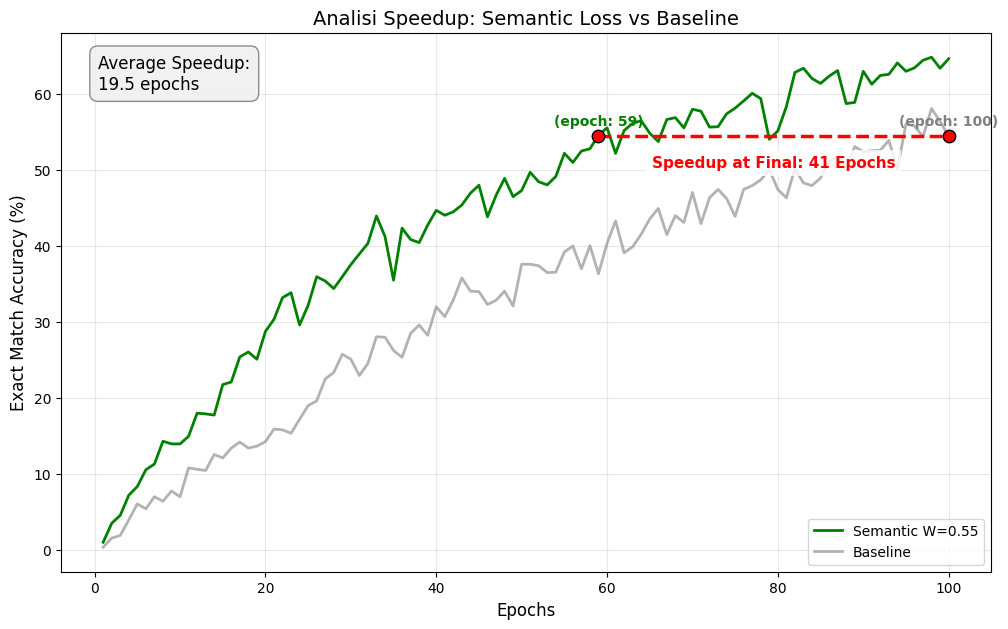

In [94]:
# ============================================================
# ANALISI DELLA VELOCITÀ DI CONVERGENZA (SPEEDUP VISUALIZZATO + MEDIA)
# ============================================================

# 1. Recupero dati
acc_semantic = results[0.55]['history']['accuracy']
acc_baseline = hist_base['accuracy']

# Creiamo asse x (epoche)
epochs_sem = range(1, len(acc_semantic) + 1)
epochs_base = range(1, len(acc_baseline) + 1)

# --- CALCOLO DELLO SPEEDUP MEDIO ---
# Calcoliamo la distanza tra le curve per ogni livello di accuracy (dal 10% al max comune)
epoch_gaps = []
max_common_acc = min(max(acc_semantic), max(acc_baseline))

# Funzione helper
def get_epoch_at_acc(acc_list, threshold):
    for ep, val in enumerate(acc_list):
        if val >= threshold:
            return ep + 1
    return None

# Campioniamo ogni 1% di accuracy
for t in range(10, int(max_common_acc)):
    e_sem = get_epoch_at_acc(acc_semantic, t)
    e_base = get_epoch_at_acc(acc_baseline, t)
    if e_sem and e_base:
        epoch_gaps.append(e_base - e_sem)

avg_speedup = np.mean(epoch_gaps) if epoch_gaps else 0.0

# --- DATI PER LA LINEA FINALE (Visualization esistente) ---
final_base_acc = acc_baseline[-1]
final_base_epoch = len(acc_baseline)
match_epoch_sem = get_epoch_at_acc(acc_semantic, final_base_acc)


# --- PLOTTING ---
plt.figure(figsize=(12, 7))
ax = plt.gca()

# Curve principali
plt.plot(epochs_sem, acc_semantic, label='Semantic W=0.55', color='green', linewidth=2)
plt.plot(epochs_base, acc_baseline, label='Baseline', color='gray', linestyle='-', linewidth=2, alpha=0.6)

if match_epoch_sem is not None:
    # Calcolo risparmio finale
    saved_epochs = final_base_epoch - match_epoch_sem
    
    # A. Disegna la linea orizzontale di collegamento
    plt.hlines(y=final_base_acc, xmin=match_epoch_sem, xmax=final_base_epoch, 
               colors='red', linestyles='--', linewidth=2.5, zorder=5)
    
    # B. Marcatori sui punti chiave (Pallini)
    plt.scatter([match_epoch_sem, final_base_epoch], [final_base_acc, final_base_acc], 
                color='red', s=80, zorder=6, edgecolors='black')

    # C. Etichetta principale SPEEDUP (Al centro della linea)
    mid_point_x = (match_epoch_sem + final_base_epoch) / 2
    plt.text(mid_point_x, final_base_acc - 2.5, 
             f"Speedup at Final: {saved_epochs} Epochs", 
             color='red', fontweight='bold', ha='center', va='top', fontsize=11, 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    # D. Etichette specifiche SOPRA i pallini
    plt.text(match_epoch_sem, final_base_acc + 1.0, f"(epoch: {match_epoch_sem})", 
             color='green', fontweight='bold', ha='center', va='bottom', fontsize=10)
    plt.text(final_base_epoch, final_base_acc + 1.0, f"(epoch: {final_base_epoch})", 
             color='gray', fontweight='bold', ha='center', va='bottom', fontsize=10)

# --- NUOVA LEGENDA IN ALTO A DESTRA (MEDIA) ---
# Usa le coordinate relative agli assi (0-1) per posizionarla fissa in alto a destra
stats_text = f"Average Speedup:\n{avg_speedup:.1f} epochs"
plt.text(0.04, 0.96, stats_text, transform=ax.transAxes, 
         fontsize=12, fontweight='normal', verticalalignment='top', horizontalalignment='left',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='#f0f0f0', alpha=0.9, edgecolor='gray'))

plt.title("Analisi Speedup: Semantic Loss vs Baseline", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Exact Match Accuracy (%)", fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Salva
plt.savefig('speedup_analysis_avg.png', dpi=300)
print(f"Grafico salvato come 'speedup_analysis_avg.png'.")
print(f"Average Speedup calculated across all thresholds: {avg_speedup:.2f} epochs")